In [35]:
import pandas
import numpy as np
from sympy import symbols, solve, Add, lambdify, latex
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from IPython.display import Math, Latex

In [10]:
# with open("vars.txt", "w") as fw, open("vars1_10.txt") as fr1, open("vars11_20.txt") as fr2:
#     for v in zip(fr1, fr2):
#         fw.write(" ".join(map(lambda x: x.replace("\n", ""), v)) + "\n")

In [11]:
from more_itertools import chunked
with open("vars.txt") as f:
    vals = (float(val) for val in f.read().replace(",", ".").split())
vals = list(chunked(vals, 20))

In [12]:
# Считываем вариант 2
y_index = 4
x_indexes = [3, 13, 14]
yi = np.array([val[y_index - 1] for val in vals])
xis = np.array([[val[x_index - 1] for val in vals] for x_index in x_indexes])

In [13]:
# Вывод варианта 2
xcolumns = [f"x{i}" for i in range(1,4)]
pd = pandas.DataFrame(
    list(zip(*xis, yi)),
    columns=[*xcolumns, "y"]
)
pd.set_index(xcolumns, inplace=True)
display(pd)

y
x1   x2   x3        
16.5 21.9 24.8  47.5
17.0 18.3 21.1  48.6
9.1  11.2 14.1  26.8
3.2  8.6  17.4  18.9
3.7  14.8 16.6  20.5
14.7 22.0 24.3  36.1
15.0 20.4 22.9  35.6
14.0 16.4 21.4  41.4
3.2  14.1 16.8  14.5
7.3  8.0  17.3  24.5
16.6 10.2 18.6  47.1
13.1 20.0 23.8  39.3
9.4  21.8 25.9  27.2
3.0  20.4 22.8  10.5
3.5  19.9 24.1  17.3
8.6  17.5 18.7  26.1
16.5 13.1 20.9  47.3
17.0 8.1  16.9  41.1
16.9 12.0 17.6  39.9
11.2 18.1 18.1  35.1
8.6  20.3 23.1  26.4
4.1  12.8 16.1  16.4
3.5  8.0  10.7  11.8
3.1  17.4 19.7  13.7
6.6  18.7 18.4  21.3
16.7 19.0 20.5  40.1
16.1 20.1 25.8  45.6
15.5 22.0 20.8  40.1
13.8 14.2 21.5  39.6
3.6  8.1  13.7  18.4

In [14]:
# Вычисление возможных 
arr = [yi, *xis]
stds = [np.std(val) for val in arr]
means = [np.mean(val) for val in arr]
corrs = dict()
for k1 in range(4):
    for k2 in range(4):
        key = frozenset([k1, k2])
        if k1 == k2 or key in corrs:
            continue
        else:
            v1v2mean = np.mean(arr[k1]*arr[k2])
            v1mean = means[k1]
            v2mean = means[k2]
            v1std = stds[k1]
            v2std = stds[k2]
            corrs[key] = (v1v2mean - v1mean*v2mean)/(v1std*v2std)

In [15]:
# Предварительная подготовка матрицы 
matrix = np.array([
    [corrs[frozenset([k1,k2])] if k1 != k2 else 1 for k1 in range(4)]
    for k2 in range(4)
])
def del_row_column(mat, i):
    return np.delete(
        np.delete(
            mat, i, 1
        ), i, 0
    )
tmatrix = del_row_column(
    matrix,
    0
)

In [16]:
# Выведем коэффициент мультиколлинеарности
display(pandas.DataFrame(
    np.hstack( 
        ([[val] for val in ["-", *xcolumns]],
        np.vstack(
            ([*xcolumns], tmatrix)
        ))
    )
))
corr = np.linalg.det(tmatrix)
print(f"Коэффициент мультиколлинеарности = {corr}")

0                   1                   2                   3
0   -                  x1                  x2                  x3
1  x1                 1.0  0.2380791900938239  0.4158004310810937
2  x2  0.2380791900938239                 1.0  0.8173972926088869
3  x3  0.4158004310810937  0.8173972926088869                 1.0

Коэффициент мультиколлинеарности = 0.2641238899203234


In [17]:
# Выведем результаты корреляции переменных если убирать одну из них
for i in range(3):
    print(f"Убираем {xcolumns[i]}")
    corr = corrs[frozenset(map(lambda x: x+1, filter(lambda x: x != i, range(3))))]
    print(f"Коэффициент корреляции переменных {' и '.join(xcolumns[:i] + xcolumns[i+1:])} = {corr}")

Убираем x1
Коэффициент корреляции переменных x2 и x3 = 0.8173972926088869
Убираем x2
Коэффициент корреляции переменных x1 и x3 = 0.4158004310810937
Убираем x3
Коэффициент корреляции переменных x1 и x2 = 0.2380791900938239


In [18]:
matrix = np.hstack( 
    ([[val] for val in ["-", "y", *xcolumns]],
    np.vstack(
        (["y", *xcolumns], matrix)
    ))
)
pd = pandas.DataFrame(
    matrix
)
display(pd)

0                    1                   2                    3  \
0   -                    y                  x1                   x2   
1   y                  1.0  0.9697207601439903  0.21201476098828378   
2  x1   0.9697207601439903                 1.0   0.2380791900938239   
3  x2  0.21201476098828378  0.2380791900938239                  1.0   
4  x3   0.4278460738044201  0.4158004310810937   0.8173972926088869   

                    4  
0                  x3  
1  0.4278460738044201  
2  0.4158004310810937  
3  0.8173972926088869  
4                 1.0

In [19]:
# Попробуем исключить x3 из регрессии потому что он слабо влияет на результат y
xcolumns = [f"x{i}" for i in range(1,3)]
xis = list(xis)
del xis[2]
xis = np.array(xis)
pd = pandas.DataFrame(
    list(zip(*xis, yi)),
    columns=[*xcolumns, "y"]
)
pd.set_index(xcolumns, inplace=True)
display(pd)

y
x1   x2        
16.5 21.9  47.5
17.0 18.3  48.6
9.1  11.2  26.8
3.2  8.6   18.9
3.7  14.8  20.5
14.7 22.0  36.1
15.0 20.4  35.6
14.0 16.4  41.4
3.2  14.1  14.5
7.3  8.0   24.5
16.6 10.2  47.1
13.1 20.0  39.3
9.4  21.8  27.2
3.0  20.4  10.5
3.5  19.9  17.3
8.6  17.5  26.1
16.5 13.1  47.3
17.0 8.1   41.1
16.9 12.0  39.9
11.2 18.1  35.1
8.6  20.3  26.4
4.1  12.8  16.4
3.5  8.0   11.8
3.1  17.4  13.7
6.6  18.7  21.3
16.7 19.0  40.1
16.1 20.1  45.6
15.5 22.0  40.1
13.8 14.2  39.6
3.6  8.1   18.4

In [20]:
# Генерируем квадрат уравнения, с помощью них найдем коэффициенты a
class AnyOne:
    def __getitem__(self, _):
        return 1
arr = [AnyOne(), *xis]
a = symbols([f"a{i}" for i in range(3)])
expr = Add(*[
    (Add(*[arr[i][j] * a[i] for i in range(3)]) - yi[j])**2
    for j in range(len(yi))
])

In [21]:
# Смотрим полученные выражения
expr

In [22]:
# Вычисляем значения коэффициентов
a_vals = solve([
        expr.diff(a[i]) for i in range(3)
    ], a)

In [23]:
# Смотрим результаты коэффициентов
a_vals

{a0: 8.95837520401973, a1: 2.16676433910359, a2: -0.0505480561703343}

In [43]:
# Создаем уравнение с подстановкой коэффициентов
x_symbols = [1, *symbols([*xcolumns])]
expr_fun = Add(*[ai*xi for ai, xi in zip(a_vals.values(), x_symbols)])
display(Math("$"+latex(expr_fun)+"$"))

In [25]:
# Компилируем функцию
yf = lambdify(x_symbols[1:], expr_fun)

In [26]:
# Вычисляем расчетные значения y и находим сумму остатков
y_rasch = [yf(*arg) for arg in zip(*xis)]
err = [
    yi[i] -  y_rasch[i] for i in range(len(yi))
]
sum(err)

-1.071143174158351e-12

In [27]:
# Расчет индекса множественной корреляции 
R = (1 - np.std(err)/np.std(yi))**0.5
print("R =",R)

R = 0.8698025473203025


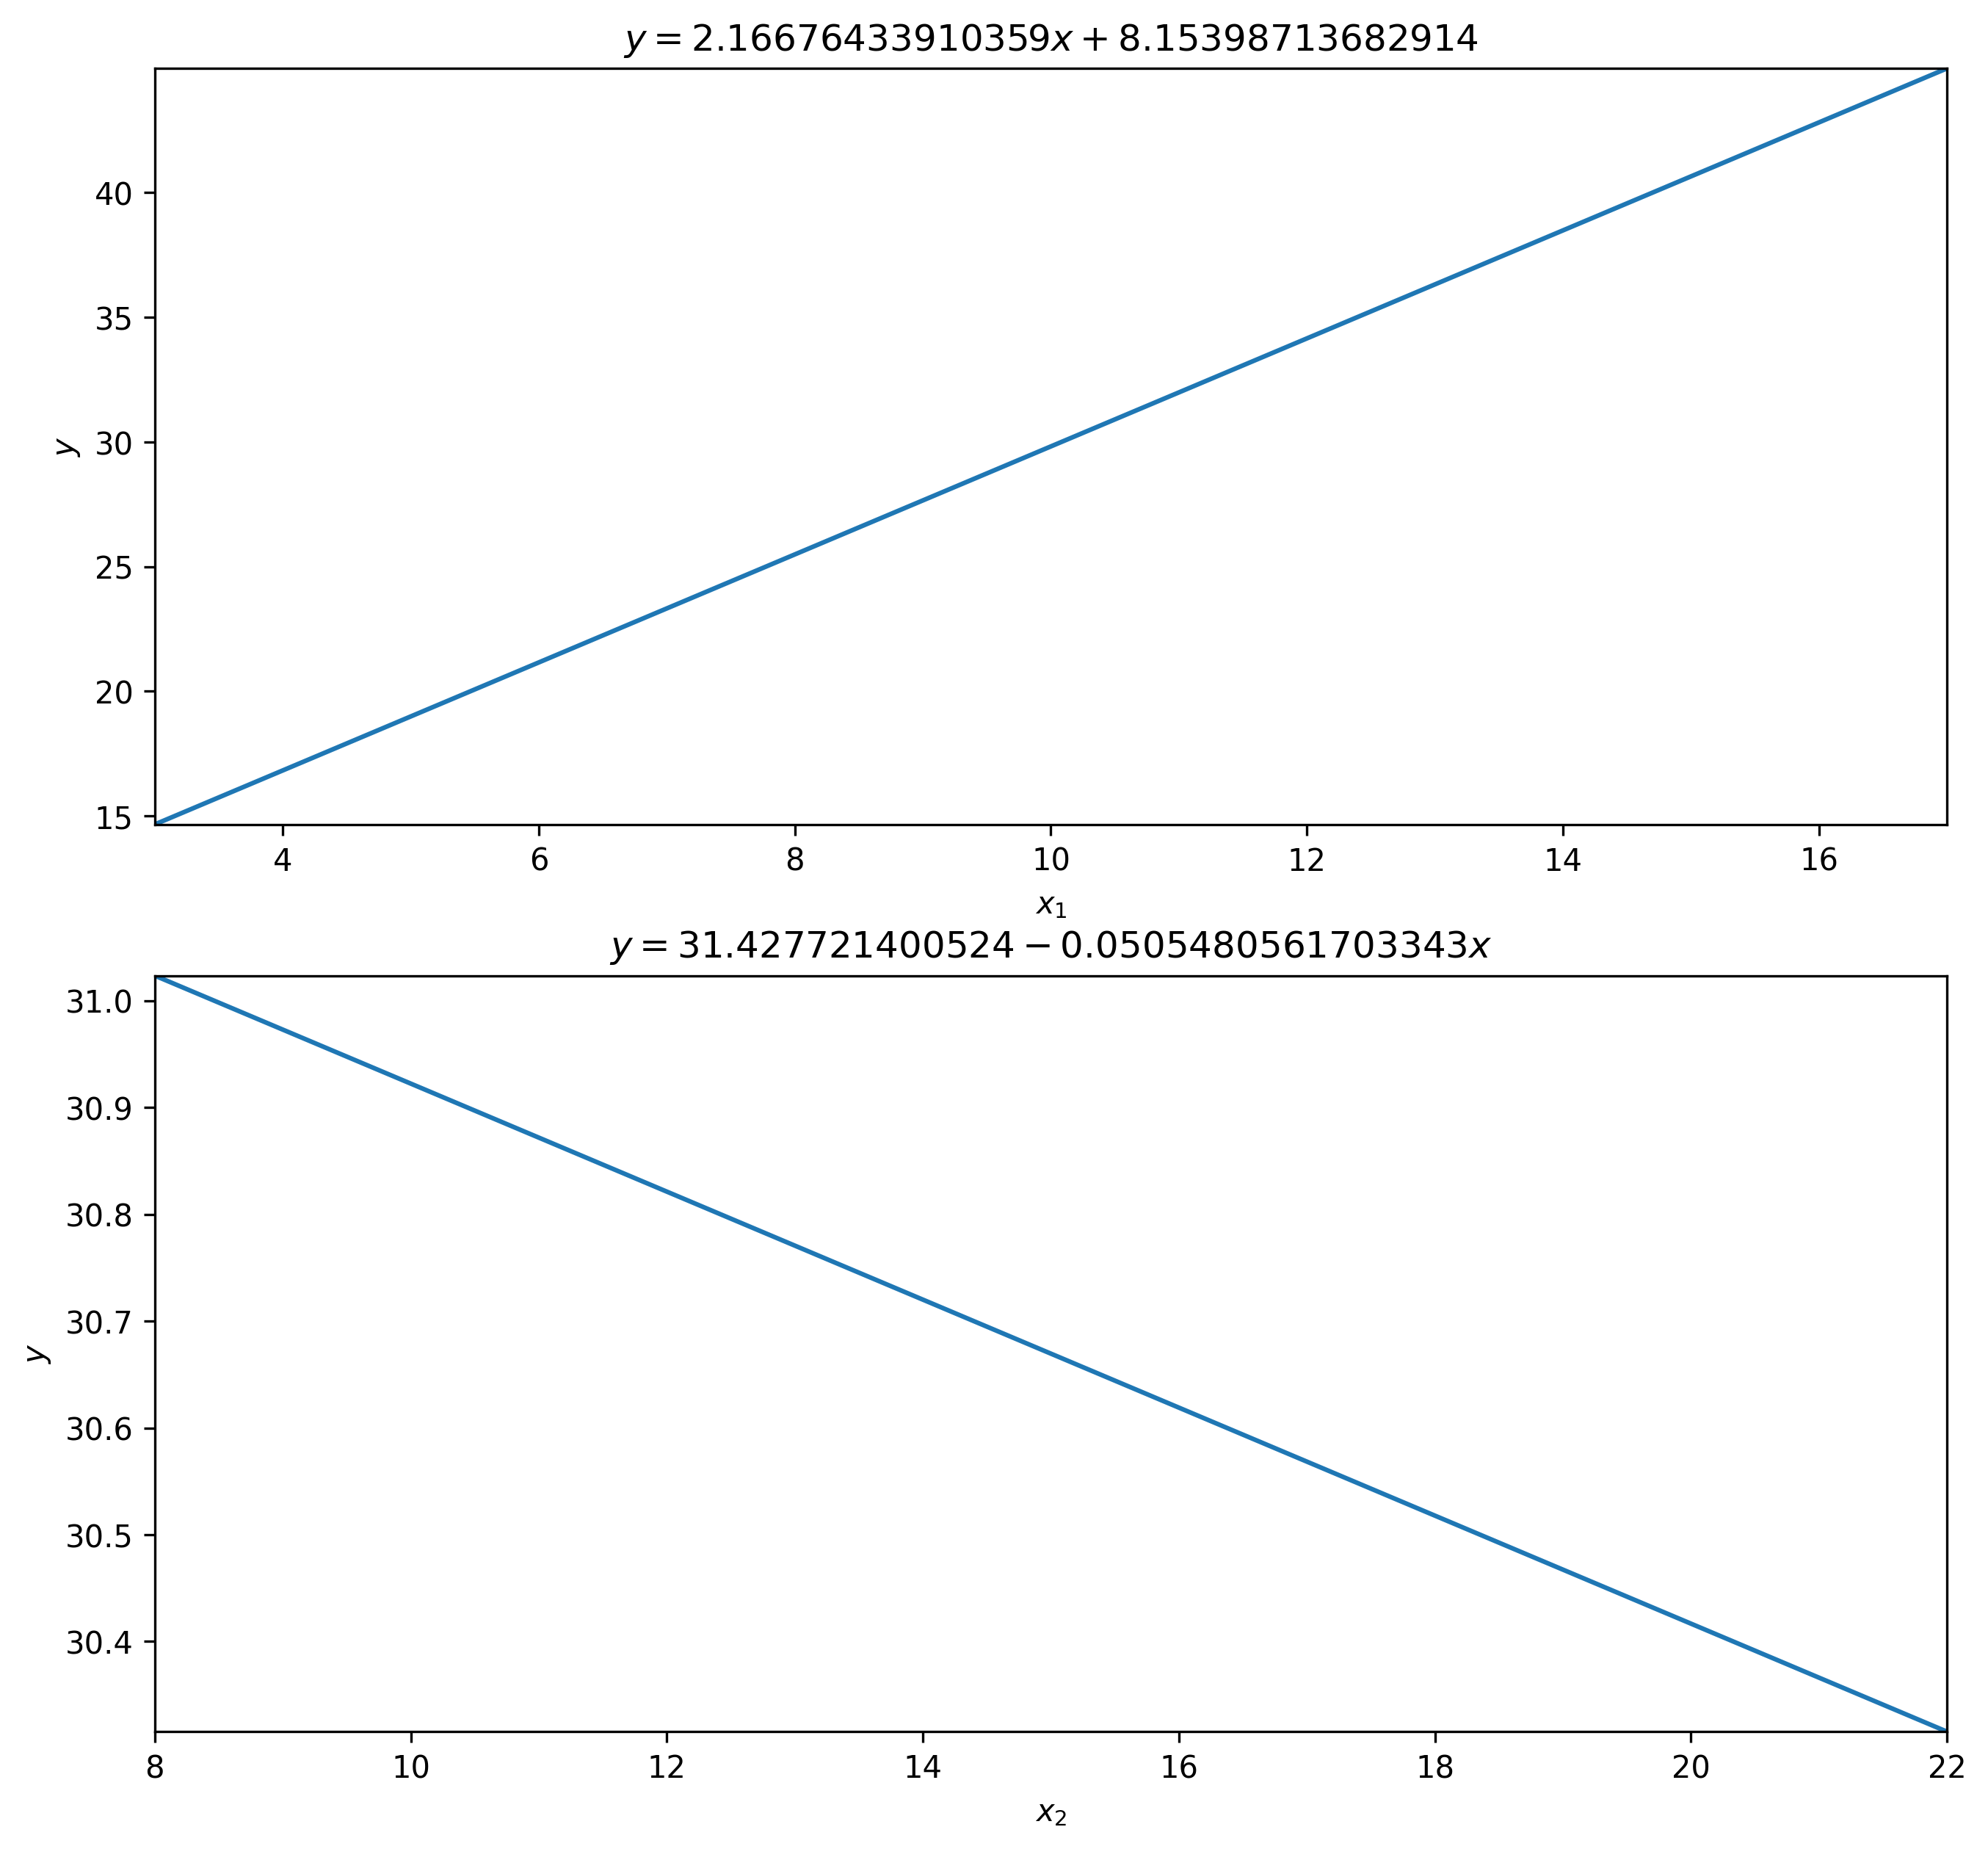

In [28]:
# Уравнения уровня
x_sym = symbols("x")
f1 = yf(x_sym, np.mean(xis[1]))
f2 = yf(np.mean(xis[0]), x_sym)
funs = [f1, f2]
minx = [np.min(v) for v in xis]
maxx = [np.max(v) for v in xis]
fig, axs = plt.subplots(2)
fig.set_size_inches(10.5, 10, forward=True)
fig.set_dpi(300)
for i, ax, fn in zip(range(2), axs, funs):
    fx = lambdify(x_sym, fn)
    xv = np.linspace(minx[i], maxx[i], 100)
    yv = [fx(x) for x in xv]
    ax.plot(xv, yv)
    ax.set_xlim(minx[i], maxx[i])
    ax.set_ylim(min(yv), max(yv))
    ax.set_title(f'$y={latex(fn)}$')
    ax.set_xlabel(f"$x_{i + 1}$")
    ax.set_ylabel("$y$")
None

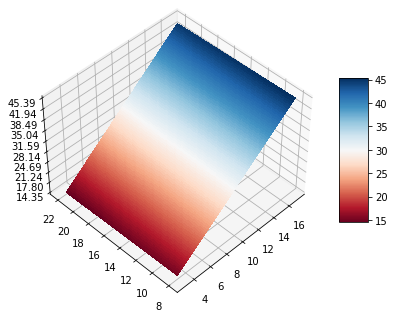

In [29]:
x1range = np.linspace(minx[0], maxx[0], 100)
x2range = np.linspace(minx[1], maxx[1], 100)
X1, X2 = np.meshgrid(x1range, x2range)
Y = yf(X1, X2)
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
surf = ax.plot_surface(X1, X2, Y, rstride=1, cstride=1,
cmap=cm.RdBu, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(45, -45 - 90)
fig.colorbar(surf, shrink=0.5, aspect=5)
None

In [30]:
# from numpy import exp,arange
# from pylab import meshgrid,cm,imshow,contour

# # the function that I'm going to plot
# def z_func(x,y):
#  return (1-(x**2+y**3))*exp(-(x**2+y**2)/2)

# fig, ax = plt.subplots()
# fig.set_dpi(300)
# x = arange(minx[0], maxx[0],0.1)
# y = arange(minx[1], maxx[1],0.1)
# X,Y = meshgrid(x, y) # grid of point
# Z = yf(X, Y) # evaluation of the function on the grid

# im = imshow(Z,cmap=cm.RdBu) # drawing the function
# # adding the Contour lines with labels
# cset = contour(Z, Y, X, levels=[10, 20, 30, 40])
# fig.colorbar(im)
# ax.set_title(f'$y={latex(expr_fun)}$')
# ax.set_xlabel("$x_1$")
# ax.set_ylabel("$x_2$")
# None